In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from numpy import cos, sin

In [3]:
from scipy.linalg import solve    
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve 

### Parameters

In [4]:
# Number of steps
N = 10

# mu
mu = 1

In [5]:
# Velocity field

def v1(x, y):
    return x + y
    
def v2(x, y):
    return y - x

### Respective functions

In [1]:
def u(x, y):
    return sin(x)*sin(y)

def f(x, y):
    return 2*sin(x)*sin(y) + v1(x,y)*cos(x)*sin(y) + v2(x,y)*cos(y)*sin(x)
    
# y = 1
def g_n(x):
    return u(x, 1)
    
# y = 0
def g_s(x):
    return u(x, 0)

# x = 0
def g_w(y):
    return u(0, y)

# x = 1
def g_e(y):
    return u(1, y)
    

### Build Diagonal Matrix

In [14]:
def A_and_b(h, mu, Ni, Ni2, N, x, y,):
    
    
    # Inner points
    xi = x[1:-1]       
    yi = y[1:-1] 
    Xi, Yi = np.meshgrid(xi, yi)
    X, Y = np.meshgrid(x, y)
    
    V1 = v1(Xi, Yi)
    V2 = v2(Xi, Yi)
    
    
    # Coefficients
    a_p = (4 * mu) / h**2
    a_e = (- mu/h**2 + V1/(2*h)).flatten()
    a_n = (- mu/h**2 + V2/(2*h)).flatten()
    a_w = (- mu/h**2 - V1/(2*h)).flatten()
    a_s = (- mu/h**2 - V2/(2*h)).flatten()
    
    
    # Add diagonals
    diag = a_p * np.ones(Ni2)
    A = np.diag(diag)
    
    diag1 = np.arange(Ni2-1)
    A[diag1, diag1+1] = a_e[0:Ni2-1]
    A[diag1+1, diag1] = a_w[1:Ni2]
    
    diag2 = np.arange(Ni2-Ni)
    A[diag2, diag2+Ni] = a_n[0:Ni2-Ni]
    A[diag2+Ni, diag2] = a_s[Ni:Ni2]
    
    
    # Fill inn b vector
    b = np.zeros(Ni2)
    for j in range(Ni):
        for i in range(Ni):
            b[j*Ni + i] = f(xi[i], yi[j])
    
    V2_s = v2(X[0,1:-1], Y[0, 1:-1])
    V1_w = v1(X[1:-1,0], Y[1:-1, 0])
    V2_n = v2(X[N,1:-1], Y[N, 1:-1])
    V1_e = v1(X[1:-1,N], Y[1:-1, N])
    
    
    # Coefficients edges
    a_e_edge = (- mu/h**2 + V1_e/(2*h)).flatten()
    a_n_edge = (- mu/h**2 + V2_n/(2*h)).flatten()
    a_w_edge = (- mu/h**2 - V1_w/(2*h)).flatten()
    a_s_edge = (- mu/h**2 - V2_s/(2*h)).flatten()
    
    
    # Include the boundary conditions
    b[0:Ni] = b[0:Ni] - a_s_edge*g_s(xi)                        # y=0
    b[Ni2-Ni:Ni2] = b[Ni2-Ni:Ni2] - a_n_edge*g_n(xi)            # y=1
    b[0:Ni2:Ni] = b[0:Ni2:Ni] - a_w_edge*g_w(yi)                # x=0
    b[Ni-1:Ni2:Ni] = b[Ni-1:Ni2:Ni] - a_e_edge*g_e(yi)          # x=1
    
    
    return A, b

### Solver Function

In [15]:
def pde_solve(N, mu, v1, v2):
    
    
    # Time run
    start = time.time()
    
    
    # Step size
    h = 1/N
    
    
    # Make grid
    x = np.linspace(0, 1, N+1)
    y = np.linspace(0, 1, N+1) 
    X, Y = np.meshgrid(x, y)
    Ni = N-1       # Number of inner points in each direction
    Ni2 = Ni**2    # Number of inner points in total
    
    
    # Exact Solution
    U_exact = u(X, Y)
    
    
    # Create A matrix
    A, b = A_and_b(h, mu, Ni, Ni2, N, x, y)
    
    
    # Handle interior stack-edges
    for i in range(1, Ni):
        edge = i*Ni
        A[edge-1, edge] = 0
        A[edge, edge-1] = 0
    
    
    # Use sparce matrix format
    A = sparse.csr_matrix(A)
    A = A.tocsr()
    
    
    # Solve system numerically
    U = spsolve(A, b)
    U = np.reshape(U, (Ni, Ni))
    
    
    # Add edges to solution
    U = np.pad(U, pad_width=1, mode='constant', constant_values=0)
    U[0, :] = g_s(x)
    U[N, :] = g_n(x)
    U[:, 0] = g_w(y)
    U[:, N] = g_e(y)
    
    error = np.max(np.max(abs(U-U_exact)))
    
    
    #Print the error
    print(f'The steplength is {1}/{N}. The error is: {error}. Runtime total: {time.time()-start}')
    
    return U, U_exact, X, Y, h

### Solutions

In [9]:
U, U_exact, X, Y, h = pde_solve(100, mu, v1, v2)

The steplength is 1/100. The error is: 3.5083767983001835e-05. Runtime total: 1.6372132301330566


### Plot Results

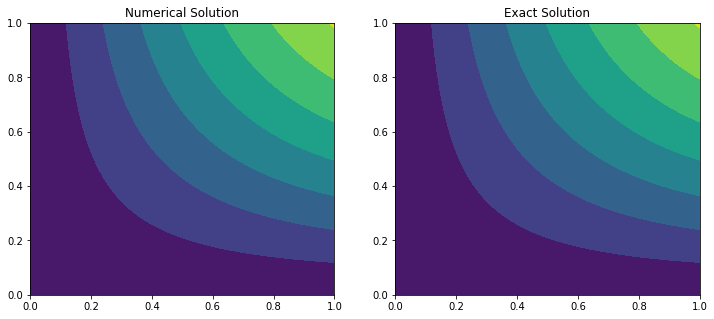

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.contourf(X, Y, U)
ax1.title.set_text('Numerical Solution')
ax2.contourf(X, Y, U_exact)
ax2.title.set_text('Exact Solution')

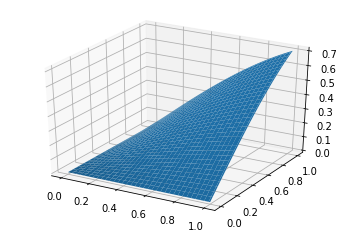

In [11]:
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, U)

In [12]:
# We want to measure the error for different stepsizes. 

def convergence(P, N, mu=1, v1=0, v2=0):
    P = P   # Number of different stepsizes
    Hconv = np.zeros(P) #list of stepsizes (x-axis)
    Econv = np.zeros(P) #list of errors (y-axis)
    N = N  # The least number of intervals (#grid points-1)
    for p in range(P):
        U, U_exact, X, Y, h = pde_solve(N, mu, v1, v2)
        Eh = U_exact-U 
        Econv[p] = np.max(np.abs(Eh))
        Hconv[p] = h #the stepsize for y and x direction are the same
        N = N*2  # Double the number of intervals
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]   # Measure the order - returns highest power first
    return Hconv, Econv, order

The steplength is 1/2. The error is: 0.023538267865691492. Runtime total: 0.0021147727966308594
The steplength is 1/4. The error is: 0.013569360296668276. Runtime total: 0.00422978401184082
The steplength is 1/8. The error is: 0.004559697544241459. Runtime total: 0.004086017608642578
The steplength is 1/16. The error is: 0.0012777250490526582. Runtime total: 0.00860285758972168
The steplength is 1/32. The error is: 0.0003342747722069328. Runtime total: 0.03222012519836426
The steplength is 1/64. The error is: 8.514890773447803e-05. Runtime total: 0.28600597381591797
The steplength is 1/128. The error is: 2.1459689262148807e-05. Runtime total: 6.1869800090789795
The steplength is 1/256. The error is: 5.384434734967414e-06. Runtime total: 109.684002161026


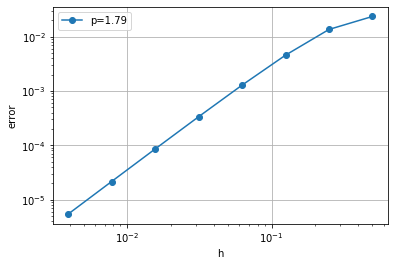

In [13]:
#convergence plot
H, E, p = convergence(8, 2)
plt.loglog(H,E,'o-', label='p={:.2f}'.format(p))
#plt.loglog(H,H*np.exp(1),'--',label='upper bound') # fyll inn upper bound (teoretisk her)
plt.grid('on')
plt.xlabel('h')
plt.ylabel('error')
plt.legend()